In [1]:
from cuopt import routing
from cuopt.routing import utils
import cudf
import pandas as pd

# Daily Deliveries
## Capacitated Vehicle Routing Problem (CVRP)

Micro fulfillment centers allow retailers to move predictable, high volume products closer to the end consumer allowing for lower costs and shorter overall delivery times.

In this scenario we have a number of same-day delivery orders that we would like to process for a given area from a given micro fulfillment center. We have the requisite number of delivery vehicles and enough time to deliver all packages over the course of a single day. Each delivery vehicle has a maximum capacity of orders  it can carry and we are looking for the route assignment that minimizes the total distance driven by all vehicles.

### Problem Details:
- 8 Locations each with an associated demand
    - 1 MFC 
        - demand: [0]
    - 7 Delivery Locations
        - demand: [4, 4, 2, 2, 1, 2, 1]
    

- 3 Delivery vehicles each with an associated capacity
    - 2 trucks
        - capacity: [8, 8]
    - 1 van
        - capacity: [4]

Below we visualize the delivery locations with respect to the MFC.  The cost from all locations to all other locations (a cost matrix) will be required for optimization. To see an example of cost matrix generation from map data or a waypoint graph, refer to the [cost_matrix_creation.ipynb](cost_matrix_creation.ipynb) notebook.  For the purpose of this simple example we will omit the cost matrix calculation.

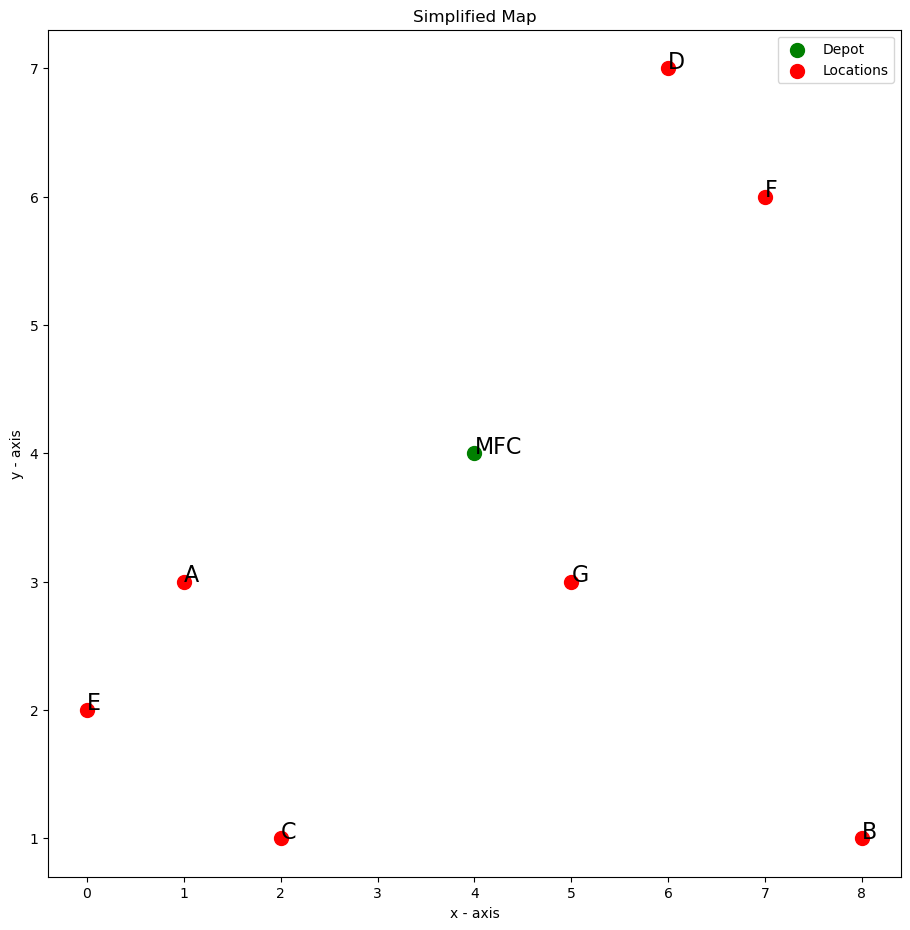

In [2]:
location_names       = [ "MFC",     "A",    "B",    "C",    "D",    "E",    "F",    "G"  ]
location_coordinates = [ [4, 4],    [1, 3], [8, 1], [2, 1], [6, 7], [0, 2], [7, 6], [5, 3] ]
location_coordinates_df = pd.DataFrame(location_coordinates, columns=['xcord', 'ycord'], index=location_names)
utils.gen_plot(location_coordinates_df).show()

### Cost Matrix

The cost matrix dictates the cost of travel between locations of interest.  The cost itself can be anything relevant to the user.  In this case we simply use distance as our cost.

Here is the cost(distance) matrix corresponding to the above locations:

In [3]:
distance_matrix = [
    [0.0, 3.1, 5.0, 3.6, 3.6, 4.5, 3.6, 1.4],
    [3.1, 0.0, 7.3, 2.2, 6.4, 1.4, 6.7, 4.0],
    [5.0, 7.3, 0.0, 6.0, 6.3, 8.1, 5.1, 3.6],
    [3.6, 2.2, 6.0, 0.0, 7.2, 2.2, 7.1, 3.6],
    [3.6, 6.4, 6.3, 7.2, 0.0, 7.8, 1.4, 4.1],
    [4.5, 1.4, 8.1, 2.2, 7.8, 0.0, 8.1, 5.1],
    [3.6, 6.7, 5.1, 7.1, 1.4, 8.1, 0.0, 3.6],
    [1.4, 4.0, 3.6, 3.6, 4.1, 5.1, 3.6, 0.0]
]

# Create a dataframe of this matrix
distance_matrix  = cudf.DataFrame(distance_matrix, 
                                  index=location_coordinates_df.index, 
                                  columns=location_coordinates_df.index)
distance_matrix

,MFC,A,B,C,D,E,F,G
MFC,0.0,3.1,5.0,3.6,3.6,4.5,3.6,1.4
A,3.1,0.0,7.3,2.2,6.4,1.4,6.7,4.0
B,5.0,7.3,0.0,6.0,6.3,8.1,5.1,3.6
C,3.6,2.2,6.0,0.0,7.2,2.2,7.1,3.6
D,3.6,6.4,6.3,7.2,0.0,7.8,1.4,4.1
E,4.5,1.4,8.1,2.2,7.8,0.0,8.1,5.1
F,3.6,6.7,5.1,7.1,1.4,8.1,0.0,3.6
G,1.4,4.0,3.6,3.6,4.1,5.1,3.6,0.0


 ### Demand and Capacity

Set up the demand for each location and the capacity for each vehicle

In [4]:
#                 "MFC"   "A"    "B"    "C"    "D"     "E"     "F"     "G"
location_demand = [ 0,     4,     4,     2,     2,      1,      2,      1]


#                    Vehicle 0     Vehicle 1     Vehicle 2
vehicle_capacity = [    8,             8,            4     ]

### cuOpt DataModel View

Set up the cuOpt DataModel.

In [5]:
n_locations = len(location_demand)
n_vehicles = len(vehicle_capacity)

data_model = routing.DataModel(n_locations, n_vehicles)

# set the cost matrix
data_model.add_cost_matrix(distance_matrix)

# add a capacity dimension for the deliveries
data_model.add_capacity_dimension(
    "deliveries",
    cudf.Series(location_demand),
    cudf.Series(vehicle_capacity)
)

### CuOpt SolverSettings

Set up cuOpt SolverSettings.

In [6]:
solver_settings = routing.SolverSettings()

# set number of climbers that will try to search for an optimal routes in parallel
solver_settings.set_number_of_climbers(128)

# solver_settings will run for given time limit.  Larger and/or more complex problems may require more time.
solver_settings.set_time_limit(0.01)


### Solution

In [7]:
routing_solution = routing.Solve(data_model, solver_settings)
if routing_solution.get_status() == 0:
    print("Cost for the routing in distance: ", routing_solution.final_cost)
    print("Vehicle count to complete routing: ", routing_solution.vehicle_count)
    utils.show_vehicle_routes(routing_solution.route, location_names)
    routing_solution.route
else:
    print("NVIDIA cuOpt Failed to find a solution with status : ", routing_solution.get_status())

Cost for the routing in distance:  26.799999237060547
Vehicle count to complete routing:  2
For vehicle - 0 route is: 

MFC->A->E->C->G->MFC


For vehicle - 1 route is: 

MFC->B->F->D->MFC




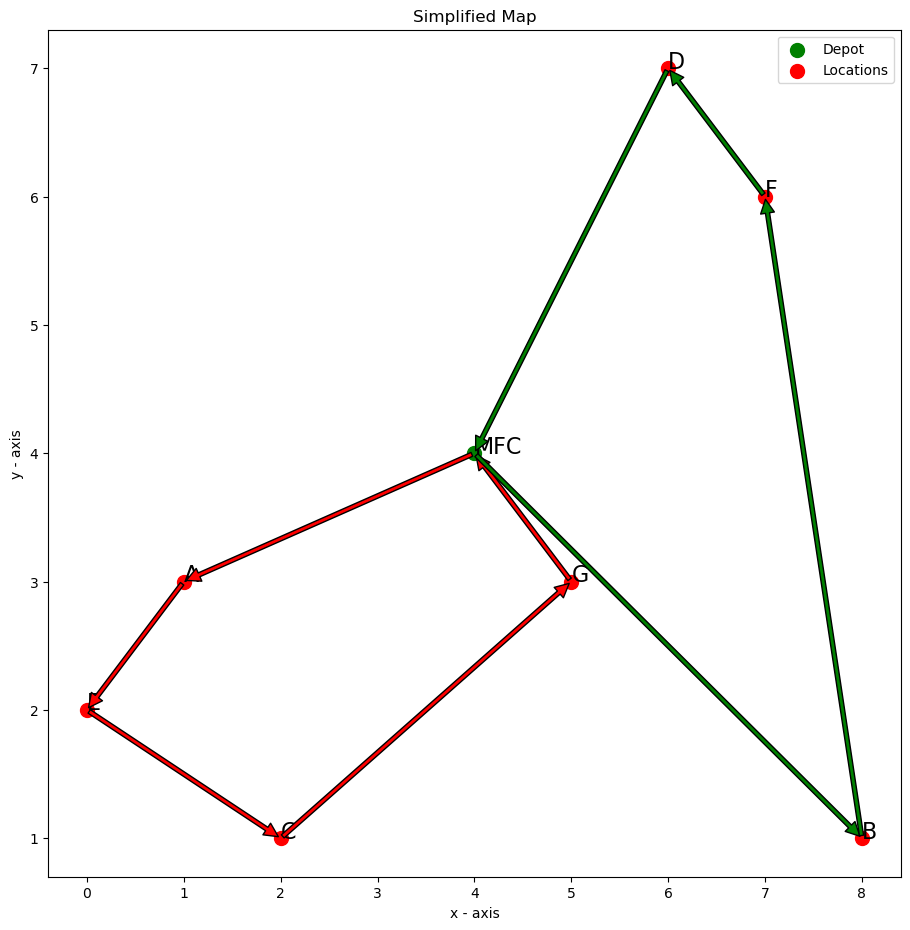

In [8]:
vehicle_colors = ["red", "green", "blue"]
utils.map_vehicle_routes(location_coordinates_df, routing_solution.route, vehicle_colors).show()

### Additional Constraints 
##### Minimum Vehicles

cuOpt has found a solution that does not require all available vehicles because the combined capacity of the two larger vehicles (16) is equal to total location demand (16).  In some cases, this is a great solution as it gives the option to save on the costs associated with additional vehicles.  In other cases there is value to assigning all available resources.  In the latter case we can require that cuOpt use all 3 available vehicles and re-solve the problem with this constraint.

In [9]:
data_model.set_min_vehicles(n_vehicles)

routing_solution = routing.Solve(data_model, solver_settings)
if routing_solution.get_status() == 0:
    print("Cost for the routing in distance: ", routing_solution.final_cost)
    print("Vehicle count to complete routing: ", routing_solution.vehicle_count)
    utils.show_vehicle_routes(routing_solution.route, location_names)
    routing_solution.route
else:
    print("NVIDIA cuOpt Failed to find a solution with status : ", routing_solution.get_status())

Cost for the routing in distance:  28.19999885559082
Vehicle count to complete routing:  3
For vehicle - 0 route is: 

MFC->D->F->B->MFC


For vehicle - 1 route is: 

MFC->A->E->C->MFC


For vehicle - 2 route is: 

MFC->G->MFC




In [10]:
routing_solution.route

,route,arrival_stamp,truck_id,location,type
0,0,0.000000,1,0,Depot
1,1,3.100000,1,1,Delivery
2,5,4.500000,1,5,Delivery
3,3,6.700000,1,3,Delivery
4,0,10.299999,1,0,Depot
5,0,0.000000,0,0,Depot
6,4,3.600000,0,4,Delivery
7,6,5.000000,0,6,Delivery
8,2,10.100000,0,2,Delivery
9,0,15.100000,0,0,Depot


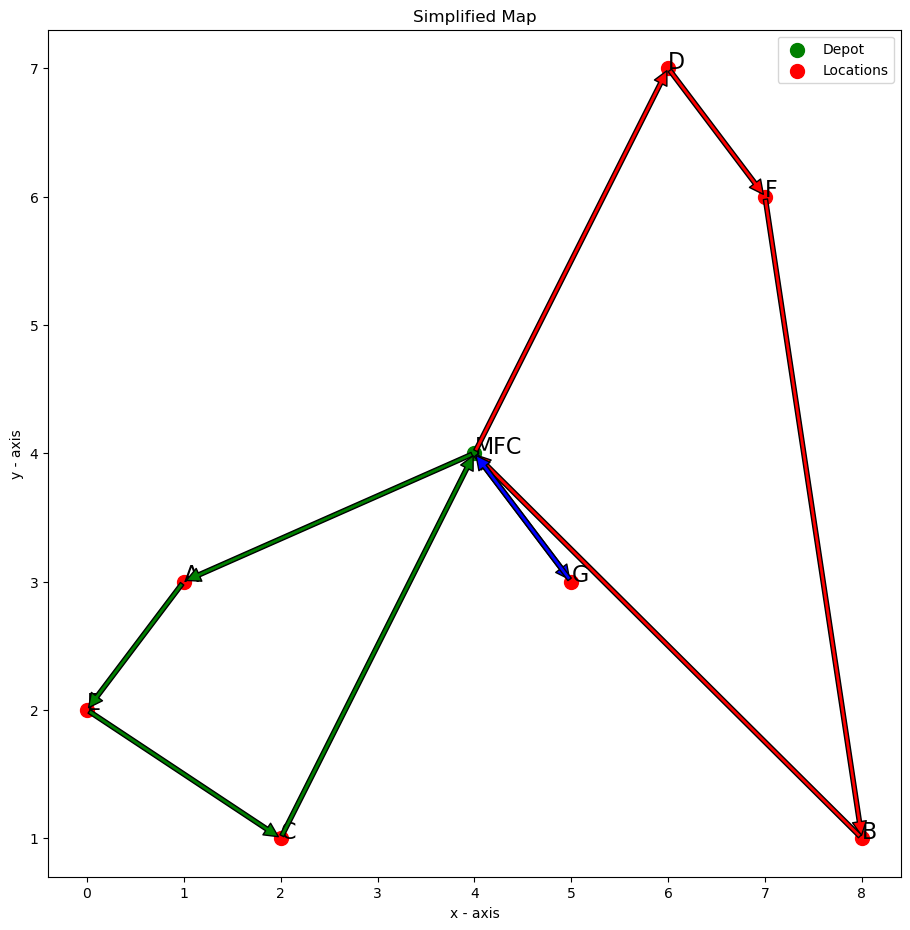

In [11]:
utils.map_vehicle_routes(location_coordinates_df, routing_solution.route, vehicle_colors).show()